# Importación de módulos

In [18]:
# Instalación del módulo para pasar de Latex a Sympy.
!pip install latex2sympy2


[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [19]:
# Importación de librerías.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
import random
import csv
import itertools
from itertools import product, combinations
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.stats import multivariate_normal
import scipy.stats as stats
import sympy as sp
from sympy.utilities.lambdify import lambdify
from latex2sympy2 import latex2sympy
from IPython.display import display, Math, Latex
import string
import heapq
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import time

# Selección de hiperparámetros

In [20]:
# Función para transformar una expresión de LateX a una función de formato Numpy.
def latex_to_numpy(intervalo, variables, latex_expr):

    # Convertir las variables en formato string a objetos Sympy.
    variables_sympy = [sp.Symbol(v) for v in variables]

    # Comprobación de coherencia entre el número de variables y la dimensionalidad del intervalo.
    if len(variables_sympy) != len(intervalo):
        raise ValueError(f"El número de variables de la función debe coincidir con la dimensionalidad del intervalo de definición.")

    # Comprobación de que cada intervalo tiene exactamente dos extremos y que el extremo inferior es menor que el extremo superior.
    for i in intervalo:
        if len(i) != 2:
            raise ValueError("Cada intervalo debe tener exactamente dos extremos.")
        if i[0] >= i[1]:
            raise ValueError(f"El extremo inferior de cada intervalo debe ser menor que el extremo superior.")

    # Crear una función de Sympy a partir de la expresión.
    func_sympy = latex2sympy(latex_expr)

    # Verificar que solo se usen las variables proporcionadas.
    simbolos_usados = func_sympy.free_symbols
    for simbolo in simbolos_usados:
        if simbolo not in variables_sympy:
            raise ValueError(f"Hay variables en la expresión que no se encuentran en la lista de variables.")

    # Crear una función de Numpy usando lambdify.
    func_numpy = lambdify(variables_sympy, func_sympy, modules=['numpy'])

    return func_numpy

# Función para mostrar por pantalla la función seleccionada en formato LateX.
def mostrar_seleccion_latex(intervalo, variables, K, expresion_funcion, epsilon):
    intervalo_str = ' \\times '.join([f"[{i[0]}, {i[1]}]" for i in intervalo])
    if len(variables) == 1:
        variables_str = f"{variables[0]}"
    else:
        variables_str = ', '.join([str(v) for v in variables])
        variables_str = f"({variables_str})"

    latex_str = (
        f"\\large \\textbf{{Función}} \\\\[5pt]"
        f"\\large \\begin{{array}}{{rcl}}"
        f"f : {intervalo_str} &\\to& \\mathbb{{R}} \\\\"
        f"{variables_str} &\\mapsto& {expresion_funcion},"
        f"\\end{{array}}\quad"
        f"(\\text{{constante de Lipschitz }} L = {K})\\\\[5pt]"
        f"\\large \\textbf{{Factor de aproximación:}} \\\\[5pt]"
        f"\\large \\epsilon = {epsilon}"
    )

    display(Latex(latex_str))

In [21]:
# HIPERPARÁMETROS DE EJECUCIÓN:

# Intervalo de definición de la función. Se escribe como una lista de listas,
# cada una de las cuales tiene dos elementos, correspondientes a los extremos superior e inferior de sus proyecciones unidimensionales.
intervalo = [[-3,3]]

# Lista con las variables que se pueden usar en la expresión de la función. Se escriben en orden según la dimensión que representan,
# y debe haber tantas como indique la dimensionalidad del intervalo de definición.
variables = ['x']

# Constante de Lipschitz. La función definida posteriormente debe ser lipschitziana (en su intervalo de definición)
# con la constante de Lipschitz determinada por L (ha de ser mayor que 0).
L = 1

# Expresión de la función en formato LateX.
expresion_funcion = "\\frac{1}{3} x- \\frac{2}{3} \\sin(x) \\cos(x)"

# Factor de aproximación deseado.
epsilon = 0.1

# Número de datos con los que entrenamos la red
nDatosEntrenamiento = 100

# Número de datos mediante los cuales calculamos pesos explícitos
nDatosAElegir = 100

# Número de datos generados para validación y test
nDatosVal = 25
nDatosTest = 25

# Creación de la función en formato Numpy.
f = latex_to_numpy(intervalo, variables, expresion_funcion)
# Se muestra la selección de parámetros por pantalla.
mostrar_seleccion_latex(intervalo, variables, L, expresion_funcion, epsilon)

<IPython.core.display.Latex object>

# Algoritmo adaptativo de minimización de error en $\mathcal{L}^1([a,b])$

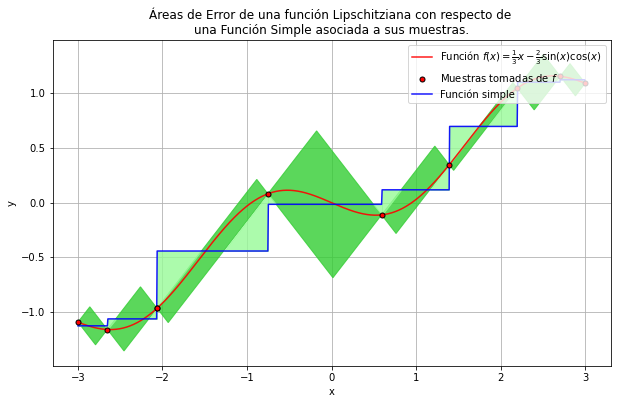

In [22]:
def figuras_lipschitz(puntos, L):
    figuras = {'poligonos': [], 'triangulos': []}

    for i in range(len(puntos) - 1):
        x1, y1 = puntos[i]
        x2, y2 = puntos[i + 1]

        interseccion_x1 = (y2 - y1 + L * (x1 + x2)) / (2 * L)
        interseccion_y1 = y1 + (y2 - y1 + L * (x2 -x1))/2

        interseccion_x2 = (y1 - y2 + L * (x1 + x2)) / (2 * L)
        interseccion_y2 = y2 - (y2 - y1 - L * (x1 - x2)) / 2


        # Calcular el punto intermedio entre y1 e y2
        medio_y = (y1 + y2) / 2

        # Definir los vértices del area donde se pueden mover las función lipschitzianas de constante L que pasa por (x1,y1) y (x2,y2)
        vertices_poligono = [(x1, y1),
                             (interseccion_x1, interseccion_y1),
                             (x2, y2),
                             (interseccion_x2, interseccion_y2)]

        figuras['poligonos'].append(vertices_poligono)

        # Definir los vértices de los triángulos que indican el error con respecto de la función simple.
        vertices_triangulo_izq = [((np.abs(y1 - y2)) / (2 * L) + x1, (y2 + y1) / 2),
                                  (x1, medio_y),
                                  (x1, y1)]

        vertices_triangulo_der = [(-(np.abs(y1 - y2)) / (2 * L) + x2, (y2 + y1) / 2),
                                  (x2, medio_y),
                                  (x2, y2)]

        figuras['triangulos'].append(vertices_triangulo_izq)
        figuras['triangulos'].append(vertices_triangulo_der)

    return figuras

def funcion_simple(x, puntos):
    for i in range(1, len(puntos)):
        x1, y1 = puntos[i - 1]
        x2, y2 = puntos[i]
        if x1 <= x < x2:
            return (y1 + y2) / 2
    return puntos[-1][1]

def graficar_figuras_lipschitz(puntos, f, a, b, L, expresion_funcion, perdida_total=None, perdida_real=None):
    figuras = figuras_lipschitz(puntos, L)

    plt.figure(figsize=(10, 6))

    # Dibujar los polígonos
    for poligono in figuras['poligonos']:
        x_poligono = [v[0] for v in poligono]
        y_poligono = [v[1] for v in poligono]
        plt.fill(x_poligono, y_poligono, color='#32CD32', alpha=0.8)

    # Dibujar los triángulos
    for triangulo in figuras['triangulos']:
        x_triangulo = [v[0] for v in triangulo]
        y_triangulo = [v[1] for v in triangulo]
        plt.fill(x_triangulo, y_triangulo, color='#98FB98', alpha=0.8)

    # Dibujar la función escogida para samplear.
    x_full = np.linspace(a, b, 1000)
    y_funcion = f(x_full)
    plt.plot(x_full, y_funcion, label=f'Función $f(x)={expresion_funcion}$', color='red', alpha=0.9)

    # Dibujar los puntos escogidos.
    x_puntos = [p[0] for p in puntos]
    y_puntos = [p[1] for p in puntos]
    plt.scatter(x_puntos, y_puntos, color='red', s=25, label='Muestras tomadas de $f$', edgecolor='black', zorder=5)

    # Dibujar la función simple
    y_simple = [funcion_simple(x, puntos) for x in x_full]
    plt.plot(x_full, y_simple, label='Función simple', color='blue', alpha=0.9)

    # Añadir leyenda con número de muestras y error máximo actual en la parte superior izquierda de la gráfica
    if perdida_total is not None and perdida_real is not None:
        plt.text(0.05, 0.95, f"Número de muestras: {len(puntos)}\nError máximo actual: {perdida_total:.4f}\nError real: {perdida_real:.4f}",
                 horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes,
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.5), zorder=10)

    plt.legend(loc='upper right')  # Ajustar la leyenda a la esquina superior derecha
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.title("Áreas de Error de una función Lipschitziana con respecto de \nuna Función Simple asociada a sus muestras.")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

def generarDatos(intervalo, n_puntos, f, L, epsilon):

    # Añadir los extremos del intervalo
    x_puntos = [intervalo[0][0], intervalo[0][1]]

    n_puntos_interior = n_puntos - 2

    np.random.seed(42)
    # Generar puntos interiores sin incluir los extremos
    puntos_interior = np.random.uniform(intervalo[0][0], intervalo[0][1], n_puntos_interior)
    puntos_interior = [x for x in puntos_interior if x != intervalo[0][0] and x != intervalo[0][1]]

    # Combinar y eliminar duplicados
    x_puntos.extend(puntos_interior)
    x_puntos = sorted(set(x_puntos))

    # Crear la lista de puntos (x, f(x))
    puntos = [(x, f(x)) for x in x_puntos]

    return puntos

def generar_ortoedros(puntos):
    ortoedros = []

    for i in range(len(puntos) - 1):
        x1, y1 = puntos[i]
        x2, y2 = puntos[i + 1]
        h = (y1 + y2) / 2
        ortoedro = [[x1, x2], h]
        ortoedros.append(ortoedro)

    return ortoedros


nDatos = 10
puntos = generarDatos(intervalo, nDatos, f, L, epsilon)

graficar_figuras_lipschitz(puntos, f, intervalo[0][0], intervalo[0][1], L, expresion_funcion)

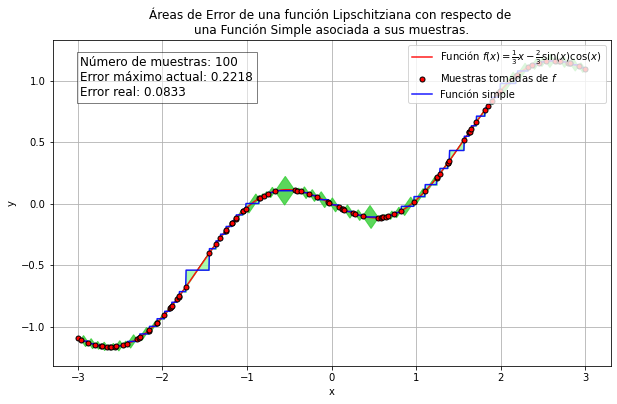

Partición generada: 

[[-3, -2.9668672972583856], -1.0981107609456118]
[[-2.9668672972583856, -2.8764930342251853], -1.115241222909014]
[[-2.8764930342251853, -2.7936688733086896], -1.1361505541258758]
[[-2.7936688733086896, -2.7286362665367716], -1.1497513611173873]
[[-2.7286362665367716, -2.721297523680014], -1.155022933720707]
[[-2.721297523680014, -2.6514983269908035], -1.158072542864011]
[[-2.6514983269908035, -2.6186498982838584], -1.1610198838904267]
[[-2.6186498982838584, -2.609690442088323], -1.1613196699375499]
[[-2.609690442088323, -2.555732089595458], -1.160175384548968]
[[-2.555732089595458, -2.552696137921375], -1.1589353390568358]
[[-2.552696137921375, -2.4690449876884832], -1.1533569448236412]
[[-2.4690449876884832, -2.413967315961697], -1.1418302999185186]
[[-2.413967315961697, -2.3047856428492217], -1.1178006498720392]
[[-2.3047856428492217, -2.28243452437019], -1.095179622736616]
[[-2.28243452437019, -2.267770590931327], -1.087291151671709]
[[-2.267770590931327, -2.1

In [23]:
class AreaError:
    def __init__(self, inicio, error):
        self.inicio = inicio
        self.error = error

    # Para mantener el área de máximo error al principio de la cola
    def __lt__(self, other):
        return self.error > other.error

# Distancia euclídea entre dos puntos
def distancia_euclidiana(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def integral_diferencia_absoluta(f, puntos):
    a,b = puntos[0][0], puntos[-1][0]
    rango_x = np.linspace(a, b, 1000)
    y_f = f(rango_x)
    y_simple = [funcion_simple(x, puntos) for x in rango_x]
    diff_abs = np.abs(y_f - y_simple)

    return np.trapz(diff_abs, rango_x)

# Cálculo del error máximo entre dos puntos
def errorMaximo(p1, p2, L):
    x1, y1 = p1
    x2, y2 = p2
    # Calcular los puntos de intersección de las líneas de Lipschitz.
    interseccion_x1 = (y2 - y1 + L * (x1 + x2)) / (2 * L)
    interseccion_y1 = y1 + (y2 - y1 + L * (x2 -x1))/2

    interseccion_x2 = (y1 - y2 + L * (x1 + x2)) / (2 * L)
    interseccion_y2 = y2 - (y2 - y1 - L * (x1 - x2)) / 2

    base_romboide = distancia_euclidiana(x1, y1, interseccion_x2, interseccion_y2)
    altura_romboide = distancia_euclidiana(x1, y1, interseccion_x1, interseccion_y1)

    area_rectangulo = (y1 - y2) ** 2 / (2 * L)

    return 0.5 * base_romboide * altura_romboide + area_rectangulo

def minimizacionError(datos, L, N):
    datosDisponibles = datos.copy()
    extremo1 = datosDisponibles[0]
    extremo2 = datosDisponibles[-1]

    datosElegidos = list([extremo1, extremo2])

    datosDisponibles.remove(extremo1)
    datosDisponibles.remove(extremo2)

    areasError = []

    errorTotal = errorMaximo(datosElegidos[0], datosElegidos[1], L)
    heapq.heappush(areasError, AreaError(0, errorTotal))
    i = 0

    # Modificar el criterio de parada según convenga
    while len(datosElegidos) < N:
        # if i % 10 == 0:
            # graficar_figuras_lipschitz(datosElegidos, f, datosElegidos[0][0], datosElegidos[-1][0], L, expresion_funcion, errorTotal, integral_diferencia_absoluta(f, datosElegidos))

        areaMaxError = heapq.heappop(areasError)
        errorActual = areaMaxError.error
        P1 = areaMaxError.inicio
        P2 = areaMaxError.inicio + 1

        # Seleccionar el punto (x, y) de datosDisponibles que minimice el nuevo error
        mejorError1 = 0
        mejorError2 = 0
        mejorError = errorActual
        mejorDato = None

        for nuevoDato in datosDisponibles:
            if datosElegidos[P1][0] < nuevoDato[0] < datosElegidos[P2][0]:
                nuevoError1 = errorMaximo(datosElegidos[P1], nuevoDato , L)
                nuevoError2 = errorMaximo(nuevoDato, datosElegidos[P2], L)
                nuevoError = nuevoError1 + nuevoError2

                if nuevoError < mejorError:
                    mejorError1 = nuevoError1
                    mejorError2 = nuevoError2
                    mejorError = nuevoError
                    mejorDato = nuevoDato


        if mejorDato is not None:
            i += 1
            datosElegidos.insert(P2, mejorDato)
            datosDisponibles.remove(mejorDato)

            for area in areasError:
                if area.inicio > P1:
                    area.inicio += 1

            heapq.heappush(areasError, AreaError(P1, mejorError1))
            heapq.heappush(areasError, AreaError(P2, mejorError2))
            errorTotal = errorTotal - errorActual + mejorError

    return datosElegidos, errorTotal

datosEntrenamiento = generarDatos(intervalo, nDatosEntrenamiento, f, L, epsilon)

x_train = [x for x,y in datosEntrenamiento]
y_train = [y for x,y in datosEntrenamiento]

# Generar datos de validación y prueba
np.random.seed(43)
x_val = np.random.uniform(intervalo[0][0], intervalo[0][1], size=(nDatosVal, 1))
y_val = f(x_val)

np.random.seed(44)
x_test = np.random.uniform(intervalo[0][0], intervalo[0][1], size=(nDatosTest, 1))
y_test = f(x_test)

datosElegidos, errorTotal = minimizacionError(datosEntrenamiento, L, nDatosAElegir)
errorReal = integral_diferencia_absoluta(f, datosElegidos)

graficar_figuras_lipschitz(datosElegidos, f, intervalo[0][0], intervalo[0][1], L, expresion_funcion, errorTotal, errorReal)

ortoedros = generar_ortoedros(datosElegidos)
print("Partición generada: \n")
for ortoedro in ortoedros:
    print(ortoedro)


# Construcción de la redes neuronales asociadas.

### Red ReLU acotada en anchura

In [24]:
def diferencia_de_areas(base, delta):
    longitudes = [proyeccion[1] - proyeccion[0] for proyeccion in base]
    area_original = np.prod(longitudes)
    area_reducida = np.prod([l - 2 * delta for l in longitudes])
    return area_original - area_reducida

def encontrar_delta(bases, epsilon_bloque):
    min_longitud = min([proyeccion[1] - proyeccion[0] for base in bases for proyeccion in base])
    delta = min_longitud / 2
    umbral = 1e-30

    while delta > umbral:  # Un umbral pequeño para evitar llegar a cero
        if all(diferencia_de_areas(base, delta) <= epsilon_bloque for base in bases):
            return delta
        delta /= 2

    return None  # Si no se encuentra un delta que cumpla la condición


N = sum(proyeccion[1] - proyeccion[0] for proyeccion in intervalo)

max_altura = max(abs(ortoedro[-1]) for ortoedro in ortoedros)

if(max_altura == 0):
  epsilon_bloque = epsilon/(len(ortoedros) * max_altura)
else:
  epsilon_bloque = epsilon

bases = [ortoedro[:-1] for ortoedro in ortoedros]
delta = encontrar_delta(bases, epsilon_bloque)

print(f"Valores calculados: N={N} y delta={delta}")

Valores calculados: N=6 y delta=7.236031870183623e-05


[[[-3, -2.9668672972583856]], [[-2.9668672972583856, -2.8764930342251853]], [[-2.8764930342251853, -2.7936688733086896]], [[-2.7936688733086896, -2.7286362665367716]], [[-2.7286362665367716, -2.721297523680014]], [[-2.721297523680014, -2.6514983269908035]], [[-2.6514983269908035, -2.6186498982838584]], [[-2.6186498982838584, -2.609690442088323]], [[-2.609690442088323, -2.555732089595458]], [[-2.555732089595458, -2.552696137921375]], [[-2.552696137921375, -2.4690449876884832]], [[-2.4690449876884832, -2.413967315961697]], [[-2.413967315961697, -2.3047856428492217]], [[-2.3047856428492217, -2.28243452437019]], [[-2.28243452437019, -2.267770590931327]], [[-2.267770590931327, -2.163036836087749]], [[-2.163036836087749, -2.154454650151424]], [[-2.154454650151424, -2.0640328779827843]], [[-2.0640328779827843, -2.0638881573453807]], [[-2.0638881573453807, -1.9768552578762508]], [[-1.9768552578762508, -1.9090501967573963]], [[-1.9090501967573963, -1.899572940879397]], [[-1.899572940879397, -1.

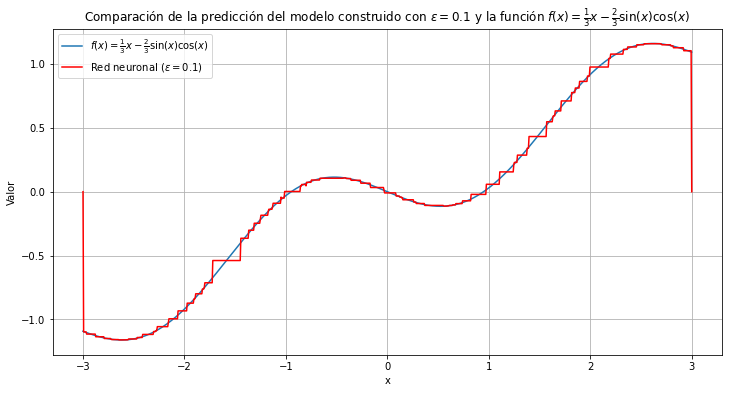

In [25]:
def bloque_neuronal_ReLU(alpha, beta, N, delta, n, dimension, ultima_altura, flag="other"):
    n_ = n-1
    dimension_ = dimension -1

    if flag != "first":
        input_size = n + 4 if flag != "second" else n+2
        hidden_layer_size = n + 4  # Tamaño de la capa oculta
        output_size = n + 4  # Tamaño de la capa de salida para el bloque
    else:
        input_size = n if dimension == 1 else n + 2
        hidden_layer_size = n + 2  # Tamaño de la capa oculta
        output_size = n + 2  # Tamaño de la capa de salida para el bloque

    # Definir los extremos ajustados con N.
    alpha = alpha + N
    beta = beta + N

    # Pesos y biases de la PRIMERA CAPA.
    pesos1 = np.zeros((input_size, hidden_layer_size), dtype=np.float32)
    for i in range(n):
        pesos1[i, i] = 1

    pesos1[dimension_, n_ + 2] = 1

    if dimension > 1:
        pesos1[n_ + 1, n_ + 1] = 1

    biases1 = np.zeros(hidden_layer_size, dtype=np.float32)

    biases1[n_ + 2] = delta - beta

    if flag != "first":
        if ultima_altura >= 0:
            pesos1[n_ + 1, n_ + 3] = ultima_altura
        else:
            pesos1[n_ + 1, n_ + 4] = abs(ultima_altura)

        if flag != "second":
            pesos1[n_ + 3, n_ + 3] = 1
            pesos1[n_ + 4, n_ + 4] = 1

    else:
        if dimension == 1:
            for i in range(n):
                biases1[i] = N  # Establecer los biases a N

            biases1[n_ + 2] += N

    # Pesos y biases de la SEGUNDA CAPA.
    pesos2 = np.zeros((hidden_layer_size, hidden_layer_size), dtype=np.float32)
    for i in range(n):
        pesos2[i, i] = 1

    pesos2[dimension_, n_ + 1] = 1  # El parámetro j define W_{j, n+1} = 1
    pesos2[n_ + 2, n_ + 2] = -1 / delta

    if flag != "first":
        pesos2[n_ + 3, n_ + 3] = 1
        pesos2[n_ + 4, n_ + 4] = 1

    biases2 = np.zeros(hidden_layer_size, dtype=np.float32)

    biases2[n_ + 1] = -alpha

    if(dimension > 1):
        pesos2[n_ + 1, n_ + 2] = 1
    else:
        biases2[n_ + 2] = 1

    # Pesos y biases de la TERCERA CAPA.

    pesos3 = np.zeros((hidden_layer_size, hidden_layer_size), dtype=np.float32)
    for i in range(n):
        pesos3[i, i] = 1
    pesos3[n_ + 1, n_ + 1] = -1 / delta
    pesos3[n_ + 2, n_ + 2] = 1

    if flag != "first":
        pesos3[n_ + 3, n_ + 3] = 1
        pesos3[n_ + 4, n_ + 4] = 1

    biases3 = np.zeros(hidden_layer_size, dtype=np.float32)
    biases3[n_ + 1] = 1

    # Pesos y biases de la ÚLTIMA CAPA.
    pesos4 = np.zeros((hidden_layer_size, output_size), dtype=np.float32)
    for i in range(n):
        pesos4[i, i] = 1
    pesos4[n_ + 1, n_ + 1] = -1
    pesos4[n_ + 2, n_ + 1] = 1

    if flag != "first":
        pesos4[n_ + 3, n_ + 3] = 1
        pesos4[n_ + 4, n_ + 4] = 1

    biases4 = np.zeros(output_size, dtype=np.float32)

    pesos = [pesos1, pesos2, pesos3, pesos4]
    biases = [biases1, biases2, biases3, biases4]

    return pesos, biases


def red_neuronal_ReLU_anchura_acotada(ortoedros, N, delta):

    n = len(ortoedros[0])-1
    n_ = n-1

    inputs = tf.keras.Input(shape=(n,))
    x = inputs
    ultima_altura = -1  # Inicialmente no hay longitud anterior

    for i, ortoedro in enumerate(ortoedros):

        flag = "first" if (i == 0) else "second" if (i == 1) else "other"

        for i in range(n):

            alpha = ortoedro[i][0]
            beta = ortoedro[i][1]

            pesos, biases = bloque_neuronal_ReLU(alpha, beta, N, delta, n, i+1, ultima_altura, flag)
            for k in range(4):
                layer = tf.keras.layers.Dense(pesos[k].shape[1], activation='relu',
                                              kernel_initializer=tf.keras.initializers.Constant(pesos[k]),
                                              bias_initializer=tf.keras.initializers.Constant(biases[k]))
                x = layer(x)

        ultima_altura = ortoedro[-1]

    # Añadir la última capa ReLU con n+4 neuronas
    final_hidden_layer_size = n + 4
    final_pesos = np.zeros((final_hidden_layer_size, final_hidden_layer_size), dtype=np.float32)
    if ultima_altura >= 0:
        final_pesos[n_ + 1, n_ + 3] = ultima_altura
    else:
        final_pesos[n_ + 1, n_ + 4] = abs(ultima_altura)

    final_pesos[n_ + 3, n_ + 3] = 1
    final_pesos[n_ + 4, n_ + 4] = 1

    final_biases = np.zeros(final_hidden_layer_size, dtype=np.float32)
    final_hidden_layer = tf.keras.layers.Dense(final_hidden_layer_size, activation='relu',
                                               kernel_initializer=tf.keras.initializers.Constant(final_pesos),
                                               bias_initializer=tf.keras.initializers.Constant(final_biases))
    x = final_hidden_layer(x)

    # Añadir la capa final con una única salida lineal
    final_output_size = 1
    output_pesos = np.zeros((final_hidden_layer_size, final_output_size), dtype=np.float32)
    output_pesos[n_ + 3, 0] = 1
    output_pesos[n_ + 4, 0] = -1
    final_output_layer = tf.keras.layers.Dense(final_output_size, activation='linear',
                                               kernel_initializer=tf.keras.initializers.Constant(output_pesos),
                                               use_bias=False)
    x = final_output_layer(x)

    model = tf.keras.Model(inputs, x)
    return model


def graficar_salida_red(f, function_expression, epsilon, model, n, intervalo):
    if n == 1:
        x_sorted = np.linspace(intervalo[0][0], intervalo[0][1], 1000).reshape(-1, 1)
        # Predicción del modelo
        salida_pred = model.predict(x_sorted)

        # Graficar los resultados
        plt.figure(figsize=(12, 6))

        # Evaluar la función f con los argumentos desempaquetados
        plt.plot(x_sorted, [f(x[0]) for x in x_sorted], label=fr'$f(x)={function_expression}$')
        plt.plot(x_sorted, salida_pred, color='r', label=f'Red neuronal ($\epsilon = {epsilon}$)')

        plt.xlabel('x')
        plt.ylabel('Valor')
        plt.title(f'Comparación de la predicción del modelo construido con $\epsilon = {epsilon}$ y la función $f(x) = {function_expression}$')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif n == 2:
        x_sorted = np.array([[i, j] for i in np.linspace(intervalo[0][0], intervalo[0][1], 50)
                                    for j in np.linspace(intervalo[1][0], intervalo[1][1], 50)])

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Crear una malla para la función y las predicciones
        x_vals = np.linspace(intervalo[0][0], intervalo[0][1], 50)
        y_vals = np.linspace(intervalo[1][0], intervalo[1][1], 50)
        X, Y = np.meshgrid(x_vals, y_vals)

        # Evaluar la función f en la malla con los argumentos desempaquetados
        Z_f = np.array([[f(X[i, j], Y[i, j]) for j in range(X.shape[1])] for i in range(X.shape[0])])

        # Aplanar las matrices X e Y para hacer predicciones en lote
        points = np.c_[X.ravel(), Y.ravel()]
        Z_pred = model.predict(points).reshape(X.shape)

        # Graficar la predicción del modelo
        ax.plot_surface(X, Y, Z_pred, alpha=1, rstride=1, cstride=1, color='red', edgecolor='k', linewidth=0.1)

        # Graficar la función original
        ax.plot_surface(X, Y, Z_f, alpha=0.4, rstride=1, cstride=1, color='blue')

        # Crear leyendas personalizadas usando Line2D
        legend_elements = [Line2D([0], [0], color='blue', lw=4, label=fr'Función $f(x, y) = {function_expression}$'),
                           Line2D([0], [0], color='red', lw=4, label=f'Red neuronal ($\epsilon = {epsilon}$)')]

        ax.legend(handles=legend_elements)

        ax.set_title(f'Comparación de la predicción del modelo construido con $\epsilon = {epsilon}$ y la función $f(x, y) = {function_expression}$')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Valor')
        plt.show()

    else:
        print("Solo se admiten dimensiones 1D y 2D.")


N = sum(proyeccion[1] - proyeccion[0] for proyeccion in intervalo)

max_altura = max(abs(ortoedro[-1]) for ortoedro in ortoedros)
epsilon_bloque = epsilon/(len(ortoedros) * max_altura)

bases = [ortoedro[:-1] for ortoedro in ortoedros]
print(bases)

# delta = encontrar_delta(bases, epsilon_bloque)

factor = 0.3
delta = min(base[0][1] - base[0][0] for base in bases) *factor

print(f"Valores calculados: N={N} y delta={delta}")

model_horizontal_ReLU = red_neuronal_ReLU_anchura_acotada(ortoedros, N, delta)

model_horizontal_ReLU.summary()

# Obtener predicciones
y_train_pred_model_horizontal_ReLU = model_horizontal_ReLU.predict(x_train)
y_val_pred_model_horizontal_ReLU = model_horizontal_ReLU.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_horizontal_ReLU = mean_squared_error(y_train, y_train_pred_model_horizontal_ReLU)
r2_train_model_horizontal_ReLU = r2_score(y_train, y_train_pred_model_horizontal_ReLU)

# Calcular métricas en el conjunto de validación
mse_val_model_horizontal_ReLU = mean_squared_error(y_val, y_val_pred_model_horizontal_ReLU)
r2_val_model_horizontal_ReLU = r2_score(y_val, y_val_pred_model_horizontal_ReLU)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_horizontal_ReLU}\n"
      f"R²: {r2_train_model_horizontal_ReLU}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_horizontal_ReLU}\n"
      f"R²: {r2_val_model_horizontal_ReLU}\n")

# Formatear el nombre del archivo utilizando la expresión de la función lambda
#filename = f"modelos/model-horizontalReLU-[{expresion_funcion.replace(' ', '').replace('**', '^')}].keras"
# Guardar los pesos del modelo
#model_vertical.save(filename)

graficar_salida_red(f, expresion_funcion, epsilon, model_horizontal_ReLU, len(ortoedros[0])-1, intervalo)


## Red ReLU acotada en profundidad

Valores calculados: N=6 y delta=4.341619122110174e-05
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_803 (Dense)           (None, 199)               398       
                                                                 
 dense_804 (Dense)           (None, 199)               39800     
                                                                 
 dense_805 (Dense)           (None, 199)               39800     
                                                                 
 dense_806 (Dense)           (None, 199)               39800     
                                                                 
 dense_807 (Dense)           (None, 1)                 199       
                                                                 
Total

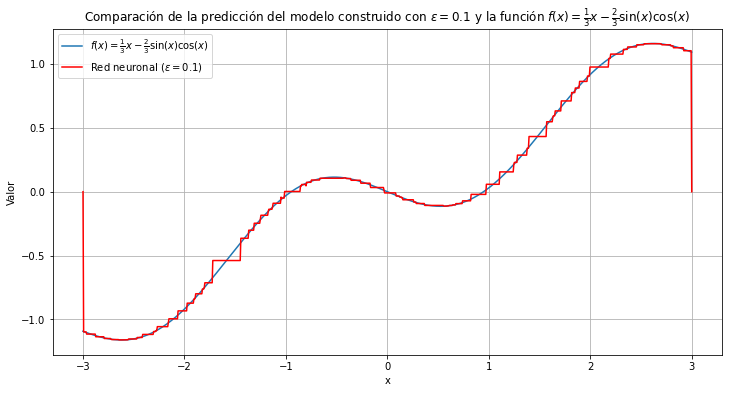

In [26]:
def red_neuronal_ReLU_profundidad_acotada(ortoedros, N, delta):
    n = len(ortoedros[0])-1

    inputs = tf.keras.Input(shape=(n,))
    x = inputs
    all_pesos = []
    all_biases = []
    ultimas_alturas = []
    ultima_altura = -1

    # Recolección de los bloques neuronales para cada ortoedro.
    for ortoedro in ortoedros:
        ortoedro_pesos = []
        ortoedro_biases = []

        for i in range(n):

            alpha = ortoedro[i][0]
            beta = ortoedro[i][1]

            pesos, biases = bloque_neuronal_ReLU(alpha, beta, N, delta, n, i+1, ultima_altura, flag="first")
            ortoedro_pesos.extend(pesos)
            ortoedro_biases.extend(biases)

        all_pesos.append(ortoedro_pesos)
        all_biases.append(ortoedro_biases)
        ultima_altura = ortoedro[-1]
        ultimas_alturas.append(ultima_altura)

    num_ortoedros = len(ortoedros)

    # Crear matrices combinadas para pesos y biases
    combined_pesos = [None] * 4 * n
    combined_biases = [None] * 4 * n

    for k in range(4 * n):

        if k == 0:

          # Fusionar los pesos de todos los bloques para la primera capa.
          # Sólo se deja una conexión para pasar el input de una capa a otra para cada neurona.
          filas_fusionadas = []
          for i in range(n):
              filas = []
              for idx, p in enumerate(all_pesos):
                  if idx == 0:
                      # Mantenemos las conexiones en el primer bloque
                      filas.append(p[0][i, :])
                  else:
                      # Eliminamos las conexiones
                      filas.append(p[0][i, n:])
              filas_fusionadas.append(np.concatenate(filas, axis=0))

          combined_pesos[k] = np.vstack(filas_fusionadas)
          #print("Pesos capa ", k, ":", combined_pesos[k])

        else:
            block_pesos = []
            for i in range(num_ortoedros):
                p_k = all_pesos[i][k]

                if i != 0:
                    # Borrar las n primeras filas y las n primeras columnas de cada bloque.
                    p_k = p_k[n:, n:]

                # Construimos las matrices de pesos de la nueva arquitectura, por bloques.
                block_row = []
                for j in range(num_ortoedros):
                    if i == j:
                        block_row.append(p_k)
                    else:
                      shape1 = 2 if i != 0 else n+2
                      shape2 = 2 if j != 0 else n+2
                      block_row.append(np.zeros((shape1, shape2)))
                block_pesos.append(np.hstack(block_row))

            combined_pesos[k] = np.vstack(block_pesos)

            # Reestructuramos las conexiones para las neuronas que se han eliminado.
            if k % 4 == 1:
              j = k // 4
              t = 1
              while (n + 2 * t) < combined_pesos[k].shape[1]:
                  combined_pesos[k][j,n + 2 * t] = 1
                  t += 1

            #print("Pesos capa ", k, ":", combined_pesos[k])


        # Procesar biases de la misma manera
        filas_biases = []
        for idx, b in enumerate(all_biases):
            if idx == 0:
                # Mantener completo el primer array
                filas_biases.append(b[k].flatten())
            else:
                # Descartar los primeros n valores de cada array subsiguiente
                filas_biases.append(b[k].flatten()[n:])

        combined_biases[k] = np.concatenate(filas_biases)
        # print("Biases capa ", k, ":", combined_biases[k], "\n")

    # Añadir capas densas con los pesos combinados.
    for k in range(4 * n):
        layer = tf.keras.layers.Dense(combined_pesos[k].shape[1], activation='relu',
                                      kernel_initializer=tf.keras.initializers.Constant(combined_pesos[k]),
                                      bias_initializer=tf.keras.initializers.Constant(combined_biases[k]))
        x = layer(x)


    # Última capa con la suma ponderada de las salidas.
    final_output_size = 1
    final_layer_input_size = combined_pesos[-1].shape[1]
    output_pesos = np.zeros((final_layer_input_size, final_output_size), dtype=np.float32)

    idx = 0

    # Establecemos los valores para calcular el valor final.
    for altura in ultimas_alturas:
        output_pesos[idx + n, 0] = altura
        idx += 2  # Incrementar para pasar al siguiente bloque

    final_output_layer = tf.keras.layers.Dense(final_output_size, activation='linear',
                                               kernel_initializer=tf.keras.initializers.Constant(output_pesos),
                                               use_bias=False)

    x = final_output_layer(x)

    model = tf.keras.Model(inputs, x)
    return model


N = sum(proyeccion[1] - proyeccion[0] for proyeccion in intervalo)

max_altura = max(abs(ortoedro[-1]) for ortoedro in ortoedros)
epsilon_bloque = epsilon/(len(ortoedros) * max_altura)

bases = [ortoedro[:-1] for ortoedro in ortoedros]
# delta = encontrar_delta(bases, epsilon_bloque)

factor = 0.3
delta = min(base[0][1] - base[0][0] for base in bases) *factor

print(f"Valores calculados: N={N} y delta={delta}")

model_vertical_ReLU = red_neuronal_ReLU_profundidad_acotada(ortoedros, N, delta)

# Ver la estructura del modelo
model_vertical_ReLU.summary()

# Obtener predicciones
y_train_pred_model_vertical_ReLU = model_vertical_ReLU.predict(x_train)
y_val_pred_model_vertical_ReLU = model_vertical_ReLU.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_vertical_ReLU = mean_squared_error(y_train, y_train_pred_model_vertical_ReLU)
r2_train_model_vertical_ReLU = r2_score(y_train, y_train_pred_model_vertical_ReLU)

# Calcular métricas en el conjunto de validación
mse_val_model_vertical_ReLU = mean_squared_error(y_val, y_val_pred_model_vertical_ReLU)
r2_val_model_vertical_ReLU = r2_score(y_val, y_val_pred_model_vertical_ReLU)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_vertical_ReLU}\n"
      f"R²: {r2_train_model_vertical_ReLU}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_vertical_ReLU}\n"
      f"R²: {r2_val_model_vertical_ReLU}\n")


# Graficar la salida inicial de la red
graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_ReLU, len(ortoedros[0])-1, intervalo)

## Red sigmoide de una sola capa

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_808 (Dense)           (None, 198)               396       
                                                                 
 dense_809 (Dense)           (None, 1)                 198       
                                                                 
Total params: 594
Trainable params: 594
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 134ms/step
Métricas en el conjunto de entrenamiento:
MSE: 0.006000471747009302
R²: 0.988854491830791

Métricas en el conjunto de validación:
MSE: 0.0009531990444019016
R²: 0.9983664239935183

32/32 [==============================] - 0s 752us/step


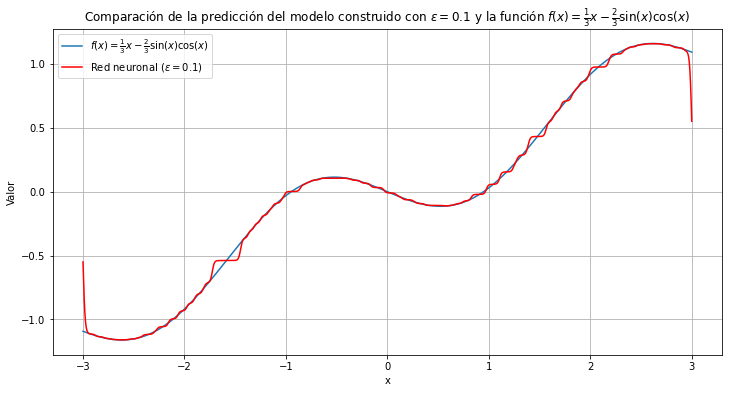

In [27]:
def red_neuronal_sigmoide_profundidad_acotada(ortoedros, delta):
    n_intervals = len(ortoedros)
    hidden_layer_size = 2 * n_intervals

    # Inicialización de pesos
    pesos1 = np.ones((1, hidden_layer_size), dtype=np.float32) / delta
    biases1 = np.zeros((hidden_layer_size,), dtype=np.float32)
    pesos2 = np.zeros((hidden_layer_size,1), dtype=np.float32)

    for j in range(n_intervals):
        biases1[2 * j] = - ortoedros[j][0][0] / delta
        biases1[2 * j + 1] = - ortoedros[j][0][1] / delta

        pesos2[2 * j, 0] = ortoedros[j][-1]
        pesos2[2 * j+1, 0] = -ortoedros[j][-1]

  # Definir el modelo
    inputs_layer = tf.keras.Input(shape=(1,))
    x = tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',
                              kernel_initializer=tf.keras.initializers.Constant(pesos1),
                              bias_initializer=tf.keras.initializers.Constant(biases1))(inputs_layer)

    # Añadir la capa densa con los pesos combinados
    output_layer = tf.keras.layers.Dense(1, activation='linear',
                                         kernel_initializer=tf.keras.initializers.Constant(pesos2),
                                         use_bias=False)(x)

    model = tf.keras.Model(inputs=inputs_layer, outputs=output_layer)

    return model


delta = 0.01
model_vertical_sigmoide = red_neuronal_sigmoide_profundidad_acotada(ortoedros, delta)

# Ver la estructura del modelo
model_vertical_sigmoide.summary()

# Obtener predicciones
y_train_pred_model_vertical_sigmoide = model_vertical_sigmoide.predict(x_train)
y_val_pred_model_vertical_sigmoide = model_vertical_sigmoide.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_vertical_sigmoide = mean_squared_error(y_train, y_train_pred_model_vertical_sigmoide)
r2_train_model_vertical_sigmoide = r2_score(y_train, y_train_pred_model_vertical_sigmoide)

# Calcular métricas en el conjunto de validación
mse_val_model_vertical_sigmoide = mean_squared_error(y_val, y_val_pred_model_vertical_sigmoide)
r2_val_model_vertical_sigmoide = r2_score(y_val, y_val_pred_model_vertical_sigmoide)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_vertical_sigmoide}\n"
      f"R²: {r2_train_model_vertical_sigmoide}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_vertical_sigmoide}\n"
      f"R²: {r2_val_model_vertical_sigmoide}\n")

# Graficar la salida inicial de la red
graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_sigmoide, len(ortoedros[0])-1, intervalo)

In [28]:
# Función para reinicializar los pesos de un modelo aleatoriamente.
def reinicializar_pesos(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            # Usar GlorotUniform para inicializar los pesos (kernel)
            kernel_initializer = tf.keras.initializers.GlorotUniform()
            layer.kernel.assign(kernel_initializer(layer.kernel.shape, dtype=layer.kernel.dtype))
        if hasattr(layer, 'bias') and layer.use_bias and layer.bias is not None:
            # Usar Zeros para inicializar los sesgos (bias)
            bias_initializer = tf.keras.initializers.Zeros()
            layer.bias.assign(bias_initializer(layer.bias.shape, dtype=layer.bias.dtype))

# Entrenamiento de las redes con pesos iniciales prefijados

## Red ReLU acotada en anchura

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_405 (Dense)           (None, 3)                 6         
                                                                 
 dense_406 (Dense)           (None, 3)                 12        
                                                                 
 dense_407 (Dense)           (None, 3)                 12        
                                                                 
 dense_408 (Dense)           (None, 3)                 12        
                                                                 
 dense_409 (Dense)           (None, 5)                 20        
                                                                 
 dense_410 (Dense)           (None, 5)                 30  

7/7 [==============================] - 63s 499ms/step - loss: 2.1809 - val_loss: 0.8504
Epoch 2/15
7/7 [==============================] - 0s 25ms/step - loss: 0.7335 - val_loss: 0.5995
Epoch 3/15
7/7 [==============================] - 0s 25ms/step - loss: 0.4211 - val_loss: 0.4869
Epoch 4/15
7/7 [==============================] - 0s 25ms/step - loss: 0.4793 - val_loss: 0.3780
Epoch 5/15
7/7 [==============================] - 0s 36ms/step - loss: 0.2645 - val_loss: 0.3327
Epoch 6/15
7/7 [==============================] - 0s 28ms/step - loss: 0.2468 - val_loss: 0.1745
Epoch 7/15
7/7 [==============================] - 0s 26ms/step - loss: 0.1545 - val_loss: 0.1482
Epoch 8/15
7/7 [==============================] - 0s 26ms/step - loss: 0.1348 - val_loss: 0.1382
Epoch 9/15
7/7 [==============================] - 0s 27ms/step - loss: 0.1331 - val_loss: 0.1230
Epoch 10/15
7/7 [==============================] - 0s 25ms/step - loss: 0.1222 - val_loss: 0.1144
Epoch 11/15
7/7 [=====================

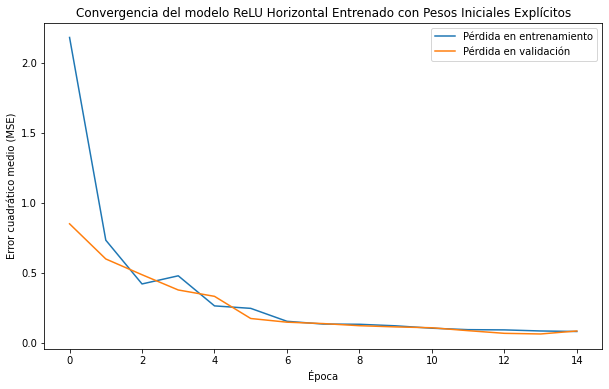

In [29]:
model_horizontal_ReLU.compile(optimizer='adam', loss='mse')
model_horizontal_ReLU.summary()

start_time = time.time()
# Entrenar el modelo y guardar el historial de entrenamiento
history_model_horizontal_ReLU = model_horizontal_ReLU.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=16)
end_time = time.time()

elapsed_time = end_time - start_time

# Obtener predicciones
y_train_pred_model_horizontal_ReLU = model_horizontal_ReLU.predict(x_train)
y_val_pred_model_horizontal_ReLU = model_horizontal_ReLU.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_horizontal_ReLU = mean_squared_error(y_train, y_train_pred_model_horizontal_ReLU)
r2_train_model_horizontal_ReLU = r2_score(y_train, y_train_pred_model_horizontal_ReLU)

# Calcular métricas en el conjunto de validación
mse_val_model_horizontal_ReLU = mean_squared_error(y_val, y_val_pred_model_horizontal_ReLU)
r2_val_model_horizontal_ReLU = r2_score(y_val, y_val_pred_model_horizontal_ReLU)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_horizontal_ReLU}\n"
      f"R²: {r2_train_model_horizontal_ReLU}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_horizontal_ReLU}\n"
      f"R²: {r2_val_model_horizontal_ReLU}\n")

print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

plt.figure(figsize=(10, 6))
plt.plot(history_model_horizontal_ReLU.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_model_horizontal_ReLU.history['val_loss'], label='Pérdida en validación')
plt.title('Convergencia del modelo ReLU Horizontal Entrenado con Pesos Iniciales Explícitos')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_405 (Dense)           (None, 3)                 6         
                                                                 
 dense_406 (Dense)           (None, 3)                 12        
                                                                 
 dense_407 (Dense)           (None, 3)                 12        
                                                                 
 dense_408 (Dense)           (None, 3)                 12        
                                                                 
 dense_409 (Dense)           (None, 5)                 20        
                                                                 
 dense_410 (Dense)           (None, 5)                 30  

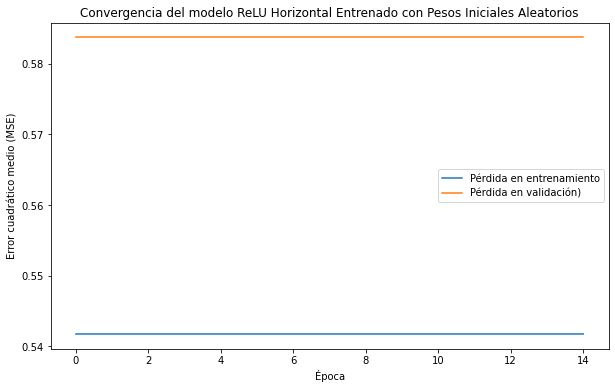

In [30]:
# Graficar la salida de la red después del entrenamiento
# graficar_salida_red(f, expresion_funcion, epsilon, model_horizontal_ReLU, len(ortoedros[0])-1, intervalo)

model_horizontal_ReLU_config = model_horizontal_ReLU.get_config()

model_horizontal_ReLU_reinicializado = tf.keras.models.Model.from_config(model_horizontal_ReLU_config)

model_horizontal_ReLU_reinicializado.compile(optimizer='adam', loss='mse')
model_horizontal_ReLU_reinicializado.summary()

# Reinicializar los pesos de los modelos
reinicializar_pesos(model_horizontal_ReLU_reinicializado)

start_time = time.time()
# Entrenar el modelo y guardar el historial de entrenamiento
history_model_horizontal_ReLU_reinicializado = model_horizontal_ReLU_reinicializado.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=16)
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
# graficar_salida_red(f, expresion_funcion, epsilon, model_horizontal_ReLU_reinicializado, len(ortoedros[0])-1, intervalo)

# Obtener predicciones
y_train_pred_model_horizontal_ReLU_reinicializado = model_horizontal_ReLU_reinicializado.predict(x_train)
y_val_pred_model_horizontal_ReLU_reinicializado = model_horizontal_ReLU_reinicializado.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_horizontal_ReLU_reinicializado = mean_squared_error(y_train, y_train_pred_model_horizontal_ReLU_reinicializado)
r2_train_model_horizontal_ReLU_reinicializado = r2_score(y_train, y_train_pred_model_horizontal_ReLU_reinicializado)

# Calcular métricas en el conjunto de validación
mse_val_model_horizontal_ReLU_reinicializado = mean_squared_error(y_val, y_val_pred_model_horizontal_ReLU_reinicializado)
r2_val_model_horizontal_ReLU_reinicializado = r2_score(y_val, y_val_pred_model_horizontal_ReLU_reinicializado)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_horizontal_ReLU_reinicializado}\n"
      f"R²: {r2_train_model_horizontal_ReLU_reinicializado}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_horizontal_ReLU_reinicializado}\n"
      f"R²: {r2_val_model_horizontal_ReLU_reinicializado}\n")

print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

plt.figure(figsize=(10, 6))
plt.plot(history_model_horizontal_ReLU_reinicializado.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_model_horizontal_ReLU_reinicializado.history['val_loss'], label='Pérdida en validación)')
plt.title('Convergencia del modelo ReLU Horizontal Entrenado con Pesos Iniciales Aleatorios')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()

# graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_ReLU_reinicializado, len(ortoedros[0])-1, intervalo)



## Red ReLU acotada en profundidad

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_803 (Dense)           (None, 199)               398       
                                                                 
 dense_804 (Dense)           (None, 199)               39800     
                                                                 
 dense_805 (Dense)           (None, 199)               39800     
                                                                 
 dense_806 (Dense)           (None, 199)               39800     
                                                                 
 dense_807 (Dense)           (None, 1)                 199       
                                                                 
Total params: 119,997
Trainable params: 119,997
Non-trainab

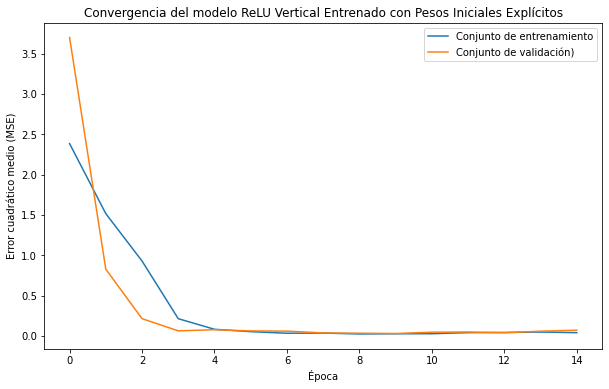

In [31]:
model_vertical_ReLU.compile(optimizer='adam', loss='mse')
model_vertical_ReLU.summary()

start_time = time.time()
# Entrenar el modelo y guardar el historial de entrenamiento
history_model_vertical_ReLU = model_vertical_ReLU.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=16)
end_time = time.time()

elapsed_time = end_time - start_time

# Obtener predicciones
y_train_pred_model_vertical_ReLU = model_vertical_ReLU.predict(x_train)
y_val_pred_model_vertical_ReLU = model_vertical_ReLU.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_vertical_ReLU = mean_squared_error(y_train, y_train_pred_model_vertical_ReLU)
r2_train_model_vertical_ReLU = r2_score(y_train, y_train_pred_model_vertical_ReLU)

# Calcular métricas en el conjunto de validación
mse_val_model_vertical_ReLU = mean_squared_error(y_val, y_val_pred_model_vertical_ReLU)
r2_val_model_vertical_ReLU = r2_score(y_val, y_val_pred_model_vertical_ReLU)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_vertical_ReLU}\n"
      f"R²: {r2_train_model_vertical_ReLU}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_vertical_ReLU}\n"
      f"R²: {r2_val_model_vertical_ReLU}\n")

print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

plt.figure(figsize=(10, 6))
plt.plot(history_model_vertical_ReLU .history['loss'], label='Conjunto de entrenamiento')
plt.plot(history_model_vertical_ReLU .history['val_loss'], label='Conjunto de validación)')
plt.title('Convergencia del modelo ReLU Vertical Entrenado con Pesos Iniciales Explícitos')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_803 (Dense)           (None, 199)               398       
                                                                 
 dense_804 (Dense)           (None, 199)               39800     
                                                                 
 dense_805 (Dense)           (None, 199)               39800     
                                                                 
 dense_806 (Dense)           (None, 199)               39800     
                                                                 
 dense_807 (Dense)           (None, 1)                 199       
                                                                 
Total params: 119,997
Trainable params: 119,997
Non-trainab

Epoch 1/20
7/7 [==============================] - 1s 22ms/step - loss: 0.2580 - val_loss: 0.0613
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0572 - val_loss: 0.0540
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0444
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.0388 - val_loss: 0.0372
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.0351
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.0287 - val_loss: 0.0259
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.0246 - val_loss: 0.0205
Epoch 8/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0217 - val_loss: 0.0165
Epoch 9/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0403
Epoch 10/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0261 - val_loss: 0.0115
Epoch 11/20
7/7 [====================

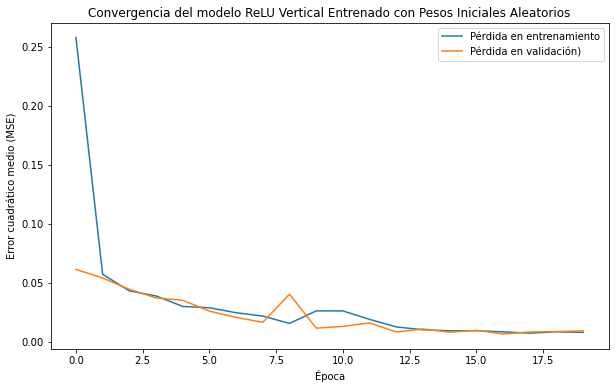

1/1 [==============================] - 0s 26ms/step


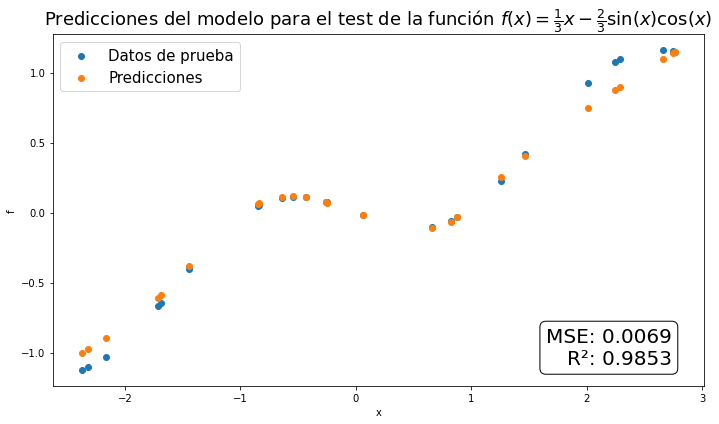

In [32]:
# Graficar la salida de la red después del entrenamiento
# graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_ReLU, len(ortoedros[0])-1, intervalo)

model_vertical_ReLU_config = model_vertical_ReLU.get_config()

model_vertical_ReLU_reinicializado = tf.keras.models.Model.from_config(model_vertical_ReLU_config)

model_vertical_ReLU_reinicializado.compile(optimizer='adam', loss='mse')

model_vertical_ReLU_reinicializado.summary()

# Reinicializar los pesos de los modelos
reinicializar_pesos(model_vertical_ReLU_reinicializado)

start_time = time.time()
history_model_vertical_ReLU_reinicializado = model_vertical_ReLU_reinicializado.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16)
end_time = time.time()

elapsed_time = end_time - start_time

# Obtener predicciones
y_train_pred_model_vertical_ReLU_reinicializado = model_vertical_ReLU_reinicializado.predict(x_train)
y_val_pred_model_vertical_ReLU_reinicializado = model_vertical_ReLU_reinicializado.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_vertical_ReLU_reinicializado = mean_squared_error(y_train, y_train_pred_model_vertical_ReLU_reinicializado)
r2_train_model_vertical_ReLU_reinicializado = r2_score(y_train, y_train_pred_model_vertical_ReLU_reinicializado)

# Calcular métricas en el conjunto de validación
mse_val_model_vertical_ReLU_reinicializado = mean_squared_error(y_val, y_val_pred_model_vertical_ReLU_reinicializado)
r2_val_model_vertical_ReLU_reinicializado = r2_score(y_val, y_val_pred_model_vertical_ReLU_reinicializado)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_vertical_ReLU_reinicializado}\n"
      f"R²: {r2_train_model_vertical_ReLU_reinicializado}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_vertical_ReLU_reinicializado}\n"
      f"R²: {r2_val_model_vertical_ReLU_reinicializado}\n")
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

plt.figure(figsize=(10, 6))
plt.plot(history_model_vertical_ReLU_reinicializado.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_model_vertical_ReLU_reinicializado.history['val_loss'], label='Pérdida en validación)')
plt.title('Convergencia del modelo ReLU Vertical Entrenado con Pesos Iniciales Aleatorios')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()

# graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_ReLU_reinicializado, len(ortoedros[0])-1, intervalo)

# Predicciones en el conjunto de prueba
y_pred_model_vertical_ReLU_reinicializado = model_vertical_ReLU_reinicializado.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred_model_vertical_ReLU_reinicializado)
r2_test = r2_score(y_test, y_pred_model_vertical_ReLU_reinicializado)

# Graficar las predicciones del conjunto de prueba junto con la función f
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, label='Datos de prueba')
plt.scatter(x_test, y_pred_model_vertical_ReLU_reinicializado, label='Predicciones')
plt.xlabel('x')
plt.ylabel('f')
plt.legend(fontsize=15)

# Añadir las métricas en un cuadro en la gráfica (abajo a la derecha)
plt.text(0.95, 0.05, f'MSE: {mse_test:.4f}\nR²: {r2_test:.4f}', 
             transform=plt.gca().transAxes, 
             fontsize=20, 
             verticalalignment='bottom', 
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Título de la gráfica
plt.title(f'Predicciones del modelo para el test de la función $f(x) = {expresion_funcion}$', fontsize=18)

plt.tight_layout()
plt.show()


## Red sigmoide de una sola capa

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_808 (Dense)           (None, 198)               396       
                                                                 
 dense_809 (Dense)           (None, 1)                 198       
                                                                 
Total params: 594
Trainable params: 594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7/7 [==============================] - 1s 23ms/step - loss: 0.0104 - val_loss: 0.0033
Epoch 2/15
7/7 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 3/15
7/7 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 4/15
7/7 [====================

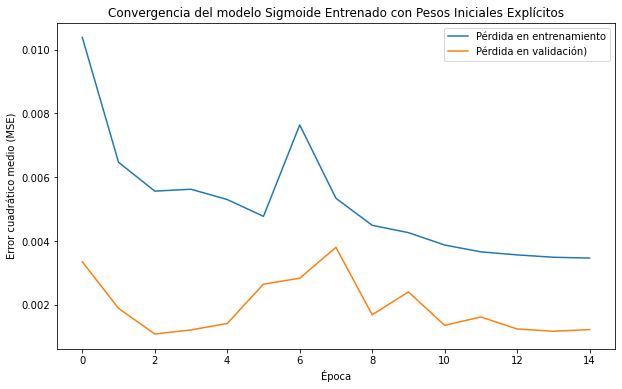

In [33]:
model_vertical_sigmoide.compile(optimizer='adam', loss='mse')
model_vertical_sigmoide.summary()

start_time = time.time()
history_model_vertical_sigmoide = model_vertical_sigmoide.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=16)

end_time = time.time()

elapsed_time = end_time - start_time

# Obtener predicciones
y_train_pred_model_vertical_sigmoide = model_vertical_sigmoide.predict(x_train)
y_val_pred_model_vertical_sigmoide = model_vertical_sigmoide.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_vertical_sigmoide = mean_squared_error(y_train, y_train_pred_model_vertical_sigmoide)
r2_train_model_vertical_sigmoide = r2_score(y_train, y_train_pred_model_vertical_sigmoide)

# Calcular métricas en el conjunto de validación
mse_val_model_vertical_sigmoide = mean_squared_error(y_val, y_val_pred_model_vertical_sigmoide)
r2_val_model_vertical_sigmoide = r2_score(y_val, y_val_pred_model_vertical_sigmoide)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_vertical_sigmoide}\n"
      f"R²: {r2_train_model_vertical_sigmoide}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_vertical_sigmoide}\n"
      f"R²: {r2_val_model_vertical_sigmoide}\n")

print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

# Graficar las pérdidas (loss) de entrenamiento y validación por separado para ambos modelos
plt.figure(figsize=(10, 6))
plt.plot(history_model_vertical_sigmoide.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_model_vertical_sigmoide.history['val_loss'], label='Pérdida en validación)')
plt.title('Convergencia del modelo Sigmoide Entrenado con Pesos Iniciales Explícitos')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_808 (Dense)           (None, 198)               396       
                                                                 
 dense_809 (Dense)           (None, 1)                 198       
                                                                 
Total params: 594
Trainable params: 594
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
7/7 [==============================] - 1s 21ms/step - loss: 0.3373 - val_loss: 0.3219
Epoch 2/15
7/7 [==============================] - 0s 27ms/step - loss: 0.2767 - val_loss: 0.2494
Epoch 3/15
7/7 [==============================] - 0s 6ms/step - loss: 0.2063 - val_loss: 0.2039
Epoch 4/15
7/7 [==============================] - 0s 7ms/step - loss: 0.1585 - val_loss: 0.1524
Epoch 5/15
7/7 [==============================] - 0s 8ms/step - loss: 0.1226 - val_loss: 0.1152
Epoch 6/15
7/7 [==============================] - 0s 6ms/step - loss: 0.0975 - val_loss: 0.0919
Epoch 7/15
7/7 [==============================] - 0s 5ms/step - loss: 0.0726 - val_loss: 0.0821
Epoch 8/15
7/7 [==============================] - 0s 5ms/step - loss: 0.0626 - val_loss: 0.0668
Epoch 9/15
7/7 [==============================] - 0s 5ms/step - loss: 0.0535 - val_loss: 0.0614
Epoch 10/15
7/7 [==============================] - 0s 5ms/step - loss: 0.0503 - val_loss: 0.0578
Epoch 11/15
7/7 [====================

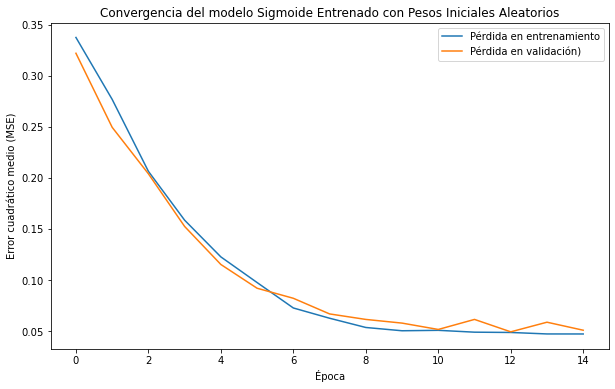

In [34]:
# Graficar la salida de la red después del entrenamiento
# graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_sigmoide, len(ortoedros[0])-1, intervalo)

model_vertical_sigmoide_config = model_vertical_sigmoide.get_config()
model_vertical_sigmoide_reinicializado = tf.keras.models.Model.from_config(model_vertical_sigmoide_config)
model_vertical_sigmoide_reinicializado.compile(optimizer='adam', loss='mse')

model_vertical_sigmoide_reinicializado.summary()

# Reinicializar los pesos de los modelos
reinicializar_pesos(model_vertical_sigmoide_reinicializado)

start_time = time.time()
history_model_vertical_sigmoide_reinicializado = model_vertical_sigmoide_reinicializado.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=16)

end_time = time.time()

elapsed_time = end_time - start_time

# graficar_salida_red(f, expresion_funcion, epsilon, model_vertical_sigmoide_reinicializado, len(ortoedros[0])-1, intervalo)

# Obtener predicciones
y_train_pred_model_vertical_sigmoide_reinicializado = model_vertical_sigmoide_reinicializado.predict(x_train)
y_val_pred_model_vertical_sigmoide_reinicializado = model_vertical_sigmoide_reinicializado.predict(x_val)

# Calcular métricas en el conjunto de entrenamiento
mse_train_model_vertical_sigmoide_reinicializado = mean_squared_error(y_train, y_train_pred_model_vertical_sigmoide_reinicializado)
r2_train_model_vertical_sigmoide_reinicializado = r2_score(y_train, y_train_pred_model_vertical_sigmoide_reinicializado)

# Calcular métricas en el conjunto de validación
mse_val_model_vertical_sigmoide_reinicializado = mean_squared_error(y_val, y_val_pred_model_vertical_sigmoide_reinicializado)
r2_val_model_vertical_sigmoide_reinicializado = r2_score(y_val, y_val_pred_model_vertical_sigmoide_reinicializado)

# Imprimir las métricas
print(f"Métricas en el conjunto de entrenamiento:\n"
      f"MSE: {mse_train_model_vertical_sigmoide_reinicializado}\n"
      f"R²: {r2_train_model_vertical_sigmoide_reinicializado}\n")

print(f"Métricas en el conjunto de validación:\n"
      f"MSE: {mse_val_model_vertical_sigmoide_reinicializado}\n"
      f"R²: {r2_val_model_vertical_sigmoide_reinicializado}\n")

print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

plt.figure(figsize=(10, 6))
plt.plot(history_model_vertical_sigmoide_reinicializado.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_model_vertical_sigmoide_reinicializado.history['val_loss'], label='Pérdida en validación)')
plt.title('Convergencia del modelo Sigmoide Entrenado con Pesos Iniciales Aleatorios')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()